In [1]:
from pathlib import Path
import pickle
import numpy as np
from lsst.daf.persistence import Butler
import lsst.afw.display as afwDisplay
import matplotlib.pyplot as plt
import lsst.afw.image as afwImage
import lsst.afw.table as afwTable
from astropy.io import fits
plt.style.use('seaborn-poster')

In [2]:
from scipy.ndimage.interpolation import rotate

Identify the single exposure warp that gives rise to the satellite streak that appears in the coadd

(15899.5, 20099.5, 31899.5, 35999.5)

<Figure size 921.6x633.6 with 0 Axes>

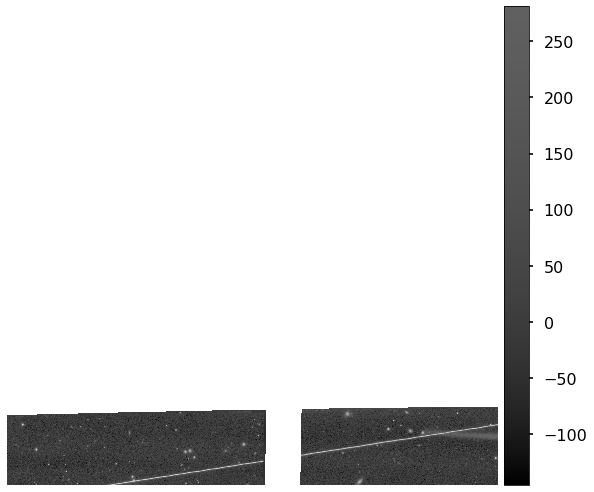

In [3]:
butler = Butler("/datasets/hsc/repo/rerun/RC/v21_0_0_rc1/DM-27597")
deepCoadd = butler.get("deepCoadd_directWarp", dataId={"tract":9813, "filter":"HSC-I", "patch":'4,8', 'visit':1246})

for maskName, maskBit in deepCoadd.mask.getMaskPlaneDict().items():
    if maskName == 'DETECTED' or maskName == 'CLIPPED' or maskName == 'STREAK':
        pass
    else:
        deepCoadd.getMask().clearMaskPlane(maskBit)
afwDisplay.setDefaultBackend('matplotlib')
plt.figure()
afw_display = afwDisplay.Display()
#afw_display.setMaskPlaneColor('CLIPPED','green')
#afw_display.setMaskPlaneColor('STREAK','red')
afw_display.setMaskTransparency(100)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(deepCoadd)
plt.gca().axis('off')

Now in the terminal run the following code to create a coadd with morpholoical filtering. This will catch the satellite streak and mask it out. The default coadditon process does not catch this streak.

assembleCoadd.py --warpCompareCoadd DM-27597 --output /home/ishasan/otherStarlink/ --selectId filter=HSC-I --id filter=HSC-I tract=9813 patch=4,8 --config doFilterMorphological=True --clobber-versions --clobber-config

In [3]:
doMorphCoadd = afwImage.exposure.ExposureF.readFits('../otherStarlink/deepCoadd/HSC-I/9813/4,8.fits')
deepCoadd = butler.get("deepCoadd", dataId={"tract":9813, "filter":"HSC-I", "patch":'4,8', 'visit':1246})

Plot the difference between the default coadd and the coadd with morphological filtering turned on. This residual image will show the satellite streak

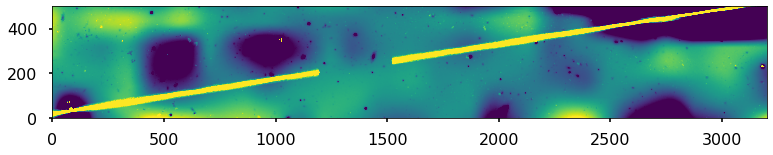

In [5]:
plt.imshow((deepCoadd.getImage().array - doMorphCoadd.getImage().array)[:500,1000:],
           vmin=-0.01, vmax=0.01, origin='lower')

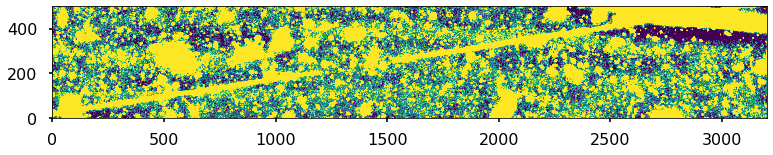

In [7]:
plt.imshow((deepCoadd.getImage().array)[:500,1000:],
           vmin=-0.01, vmax=0.01, origin='lower')

Now we will make a number of different coadds with morphological filtering, where we will adjust the mask width. 

assembleCoadd.py --warpCompareCoadd DM-27597 --output /home/ishasan/otherStarlink/ --selectId filter=HSC-I --id filter=HSC-I tract=9813 patch=4,8 --config doFilterMorphological=True maskStreaks.footprintThreshold=.1 --clobber-versions --clobber-config

Also do this for the following footprintThreshold values: .5, .7, 1.5, 1, 2, 3, 4, 5, 6, 7, 8. Rename each of the coadds to 4,8-footprintThresholdj.fits where j is the value of footprintThreshold. This will prevent overwriting the coadds

In [3]:
import matplotlib.colors as colors
plt.rcParams['xtick.minor.visible'] = True
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

In [5]:
exp = afwImage.exposure.ExposureF.readFits('../otherStarlink/deepCoadd/HSC-I/9813/4,8-footprintThreshold.1.fits')

In [9]:
pc = exp.getPhotoCalib()
calim = pc.calibrateImage(exp.getMaskedImage())

In [10]:
calim.getImage().array

array([[  0.66071707,  -2.6309943 ,  -1.2681438 , ...,  -2.9846654 ,
         -1.3217635 ,  -0.9138519 ],
       [  1.3689489 ,   2.0203817 ,  -1.1349682 , ...,  -3.0537512 ,
         -0.4565589 ,   0.06398581],
       [ -1.1010269 ,  -2.1156025 ,   1.2585944 , ...,  -0.6496748 ,
         -0.6115255 ,   0.6863886 ],
       ...,
       [  9.145805  ,   4.699985  ,  -5.2583566 , ...,  13.490198  ,
         10.224075  ,  -2.8023822 ],
       [ -4.85598   ,  -1.6894213 ,  -0.8490203 , ...,   4.067017  ,
          9.085387  , -13.495702  ],
       [ 10.876817  , -16.605856  ,   0.7725855 , ..., -12.332473  ,
         -1.0148033 ,  19.021381  ]], dtype=float32)

In [13]:
def plotProfile(path):
    #grab the coadd with morphological filtering turned on and default settings
    doMorphCoadd = afwImage.exposure.ExposureF.readFits('../otherStarlink/deepCoadd/HSC-I/9813/4,8-noStreak.fits')
    #calibrate to nJy
    pc_morphCoadd = doMorphCoadd.getPhotoCalib()
    calim_morphCoadd = pc_morphCoadd.calibrateImage(doMorphCoadd.getMaskedImage())
    
    #grab the coadd where you set the footprintThreshold 
    masked = afwImage.exposure.ExposureF.readFits(path)
    #calibrate to nJy
    pc_masked = masked.getPhotoCalib()
    calim_masked = pc.calibrateImage(masked.getMaskedImage())
    
    diffim = (calim_masked.getImage().array - calim_morphCoadd.getImage().array)[:500,1000:]
    rotim = rotate(diffim,8.5)
    fooim = rotim[400:600,200:1200]
    f, ax = plt.subplots(nrows=2)
    
    ax[0].plot(np.arange(0,200,1)*.168, fooim.mean(axis=1)*57.544)
    ax[0].set_xlabel('arcseconds')
    ax[0].set_ylabel("nJy/pixel")
#    ax[0].set_yscale('log')
#    ax[0].set_ylim([1e-3,2])
#    ax[0].set_ylim([-.01,2])
#    ax[0].xaxis.set_minor_locator(MultipleLocator(5))
    ax[1].imshow(fooim, origin='lower', vmin=-.01, vmax=.01)
    arcsec_label = [0,10,20,30]
    position = [i/.168 for i in arcsec_label]

    ax[1].set_yticks(position)
    ax[1].set_yticklabels(arcsec_label)

    ax[1].tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)
    ax[1].set_ylabel('arcseconds')
    print((fooim).sum())
    print(np.sqrt((fooim).sum()))
    return

743.1951
27.261606


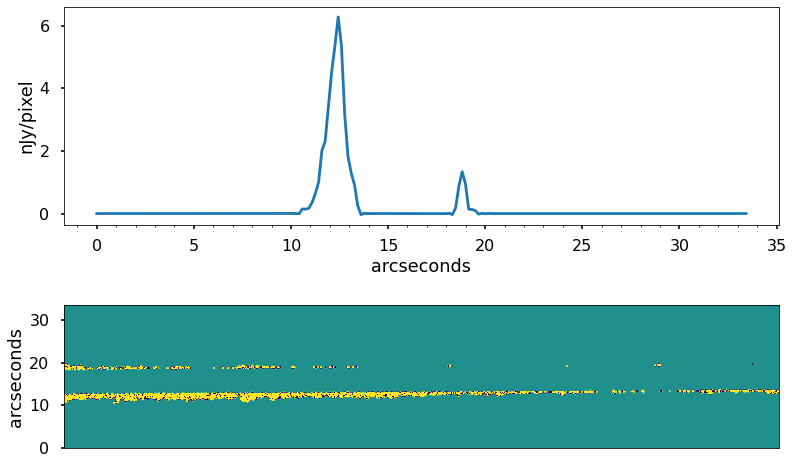

In [14]:
plotProfile('../otherStarlink/deepCoadd/HSC-I/9813/4,8-footprintThreshold.1.fits')

3744.3784
61.191326


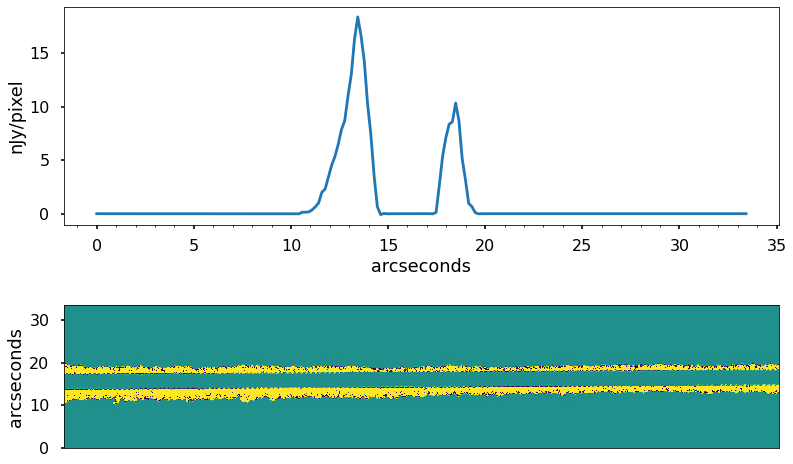

In [15]:
plotProfile('../otherStarlink/deepCoadd/HSC-I/9813/4,8-footprintThreshold.5.fits')

4793.109
69.232285


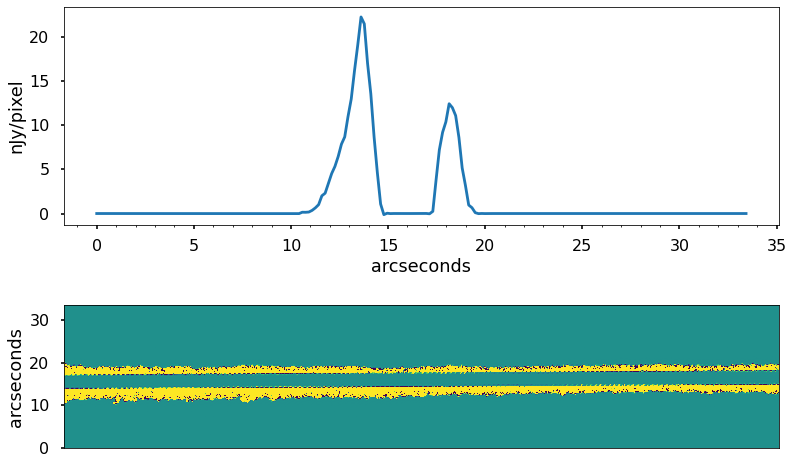

In [16]:
plotProfile('../otherStarlink/deepCoadd/HSC-I/9813/4,8-footprintThreshold.7.fits')

6157.736
78.471245


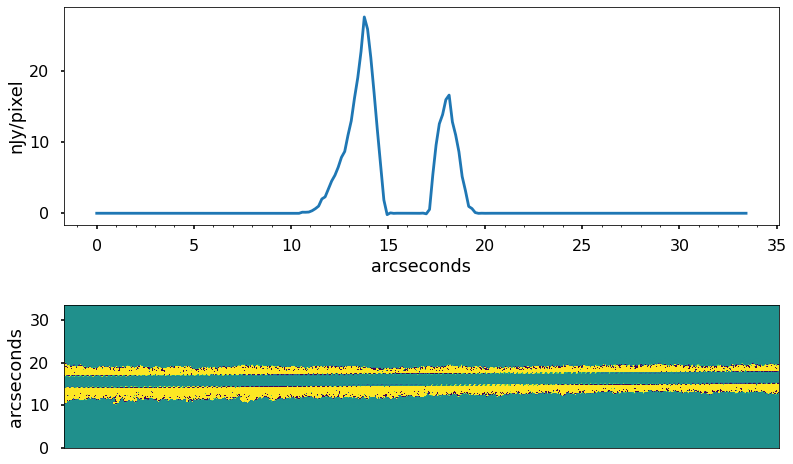

In [17]:
plotProfile('../otherStarlink/deepCoadd/HSC-I/9813/4,8-footprintThreshold1.fits')

9905.2295
99.52502


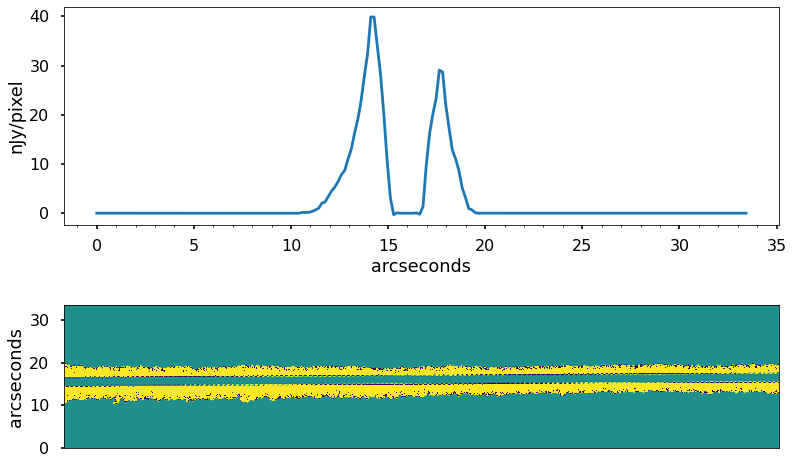

In [18]:
plotProfile('../otherStarlink/deepCoadd/HSC-I/9813/4,8-footprintThreshold2.fits')

13452.238
115.98379


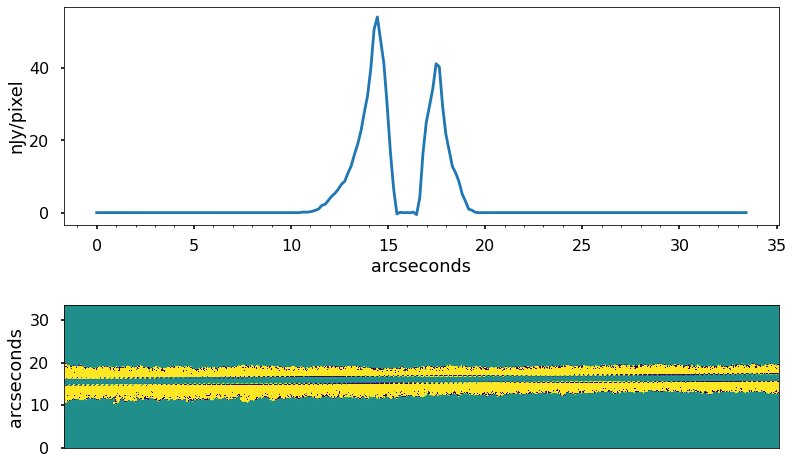

In [19]:
plotProfile('../otherStarlink/deepCoadd/HSC-I/9813/4,8-footprintThreshold3.fits')

17200.564
131.15092


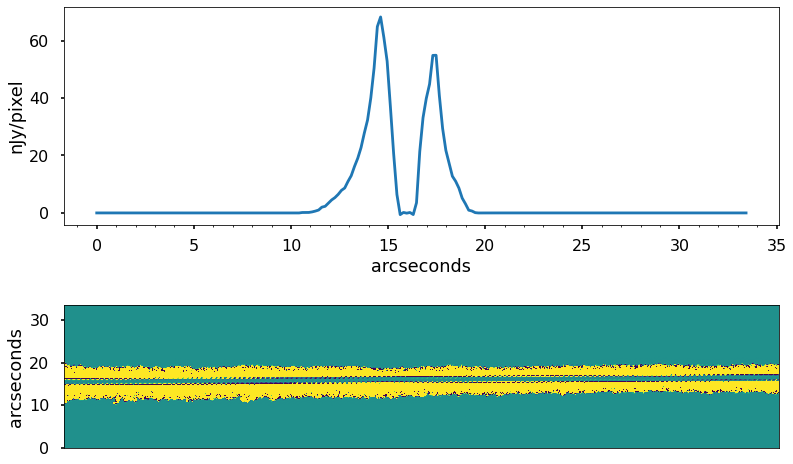

In [20]:
plotProfile('../otherStarlink/deepCoadd/HSC-I/9813/4,8-footprintThreshold4.fits')

21379.662
146.21786


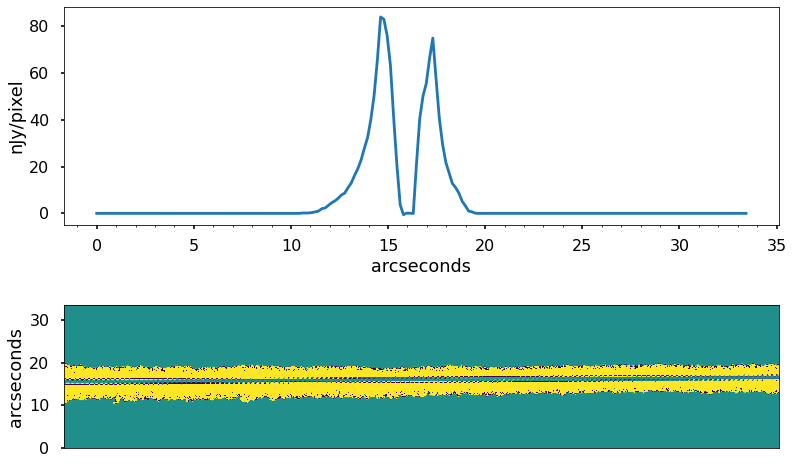

In [21]:
plotProfile('../otherStarlink/deepCoadd/HSC-I/9813/4,8-footprintThreshold5.fits')

26272.736
162.08867


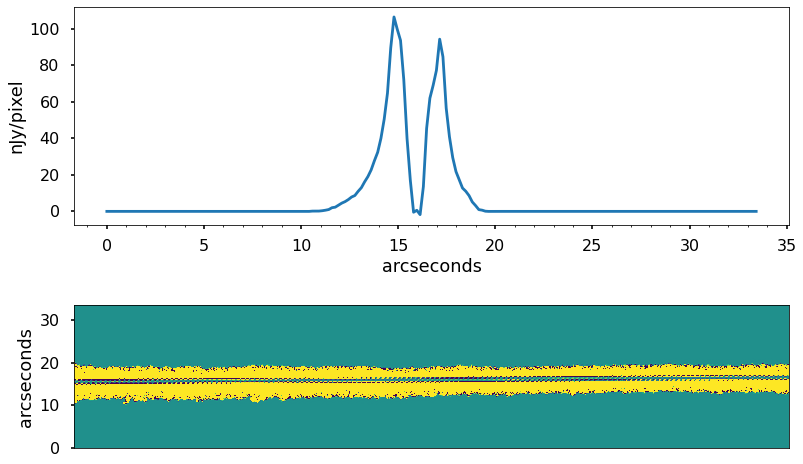

In [22]:
plotProfile('../otherStarlink/deepCoadd/HSC-I/9813/4,8-footprintThreshold6.fits')

32233.586
179.53714


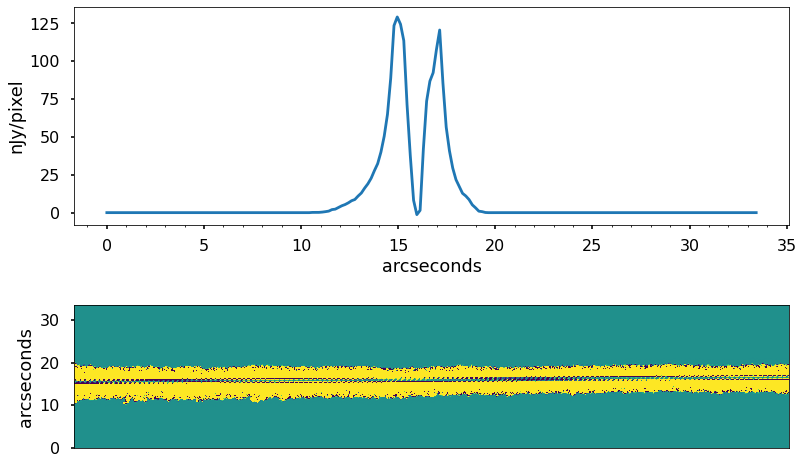

In [23]:
plotProfile('../otherStarlink/deepCoadd/HSC-I/9813/4,8-footprintThreshold7.fits')

39754.504
199.38531


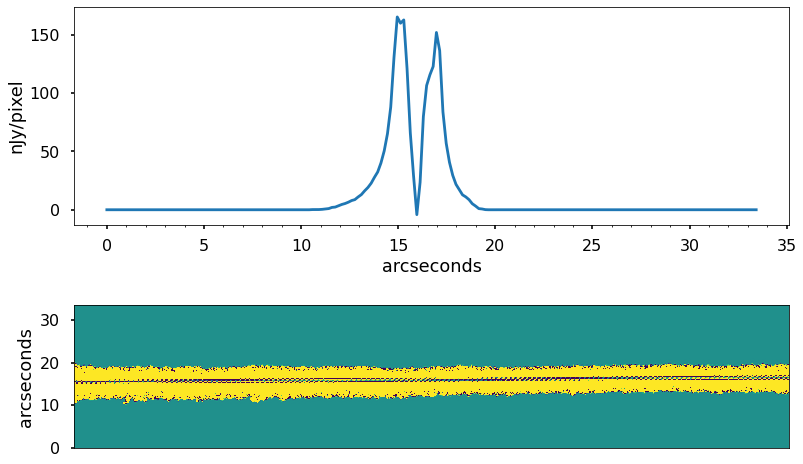

In [24]:
plotProfile('../otherStarlink/deepCoadd/HSC-I/9813/4,8-footprintThreshold8.fits')

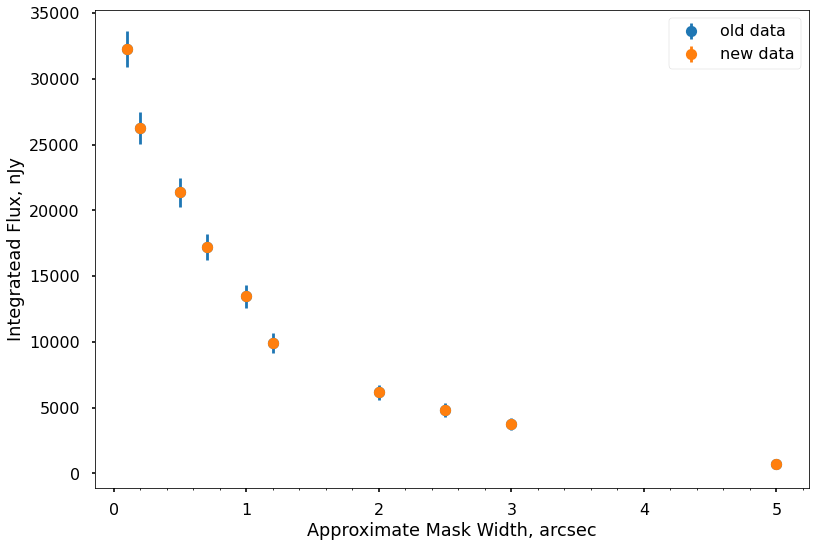

In [27]:
x_model = np.arange(.2, 5.2, .2)
xprime = [5, 3, 2.5, 2, 1.2, 1, .7, .5, .2, .1]
y = [743.1951, 3744.3784, 4793.109, 6157.736, 9905.2295, 13452.238, 17200.564, 21379.662, 26272.736, 32233.586]

#yprime = [743.19, 3744.37,4793.10, 6157.73, 9905.22, 13452.23, 17200.56, 21379.66, 26272.73, 32233.59]
#yerr = [206.800,464.183, 525.180, 595.264, 754.974, 879.827, 994.881, 1109.175, 1229.568, 1361.92]

#plt.errorbar(xprime, yprime, label='old data', yerr=yerr, fmt='o')
plt.errorbar(xprime, y, label='new data', yerr=np.sqrt(y), fmt='o')
#plt.plot(x_model, ypred, color='C0', label='best fit exponential')
plt.xlabel('Approximate Mask Width, arcsec')
plt.ylabel('Integratead Flux, nJy')
plt.legend()